In [1]:
import numpy as np
import pandas as pd
import pickle


In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

In [3]:
try:
    with open('./TrainedModels/RandomForestClassifier.pkl','rb') as rfc_file:
        classifier = pickle.load(rfc_file)
    with open('./TrainedModels/ExtraTreeRegressor.pkl','rb') as xgb_file:
        regressor = pickle.load(xgb_file)
    with open('./JoinedData.pkl','rb') as data_file:
        df = pickle.load(data_file)
        df.dropna(how='any',inplace=True)
        df.drop(columns=['FlightDate','date','ArrTime','CRSArrTime','NearestDepTime'],inplace=True)
        le = LabelEncoder()
        df['Origin'] = le.fit_transform(df['Origin'])
        df['Dest']  = le.fit_transform(df['Dest'])
        df = df.apply(pd.to_numeric)

except FileNotFoundError:
    print('Models Not saved!')

In [4]:
X = df.iloc[:,df.columns != 'ArrDel15']
y = df.iloc[:,df.columns == 'ArrDel15']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.25)
actual_delay = X_test['ArrDelayMinutes']
X_test.drop(columns=['ArrDelayMinutes'], inplace=True)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
delayed = classifier.predict(X_test)

In [6]:
delayed_filter = pd.Series(list(map(bool,delayed)))

In [7]:
delayed_flights = X_test.where(delayed_filter)
delayed_flights.dropna(how='all',inplace=True)

In [8]:
actual_delay = actual_delay.where(delayed_filter)
actual_delay.dropna(how='all', inplace=True)
input_to_regressor = delayed_flights

In [9]:
predicted_delay = regressor.predict(input_to_regressor)

In [10]:
print('Mean Squared Error is',mean_squared_error(y_pred=predicted_delay,y_true=actual_delay))

Mean Squared Error is 104.1118879056357


In [11]:
print('R^2 Score is',r2_score(actual_delay,predicted_delay))

R^2 Score is 0.9287803267661027


In [12]:
print('Mean Absolute Error is',mean_absolute_error(actual_delay,predicted_delay))

Mean Absolute Error is 7.823236914600551


In [13]:
import matplotlib 
import matplotlib.pyplot as plt

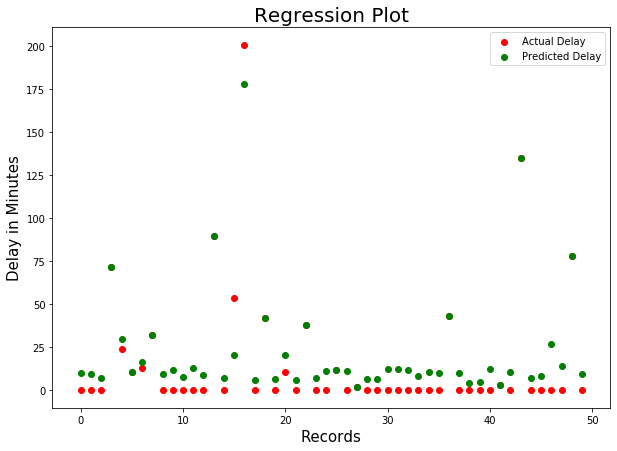

In [14]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(y=actual_delay[300:350],x=[i for i in range(50)],label='Actual Delay',c='r')
ax.scatter(y=predicted_delay[300:350],x=[i for i in range(50)],label='Predicted Delay',c='g')
ax.set_xlabel('Records',fontsize=15)
ax.set_ylabel('Delay in Minutes',fontsize=15)
ax.set_title('Regression Plot',fontsize=20)
ax.legend(loc='upper right')
plt.savefig('./Images/PiplelinedModelRegressor.png')
plt.show()